In [4]:
%pip install -Uq sagemaker docx2pdf

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install -q langchain_community langgraph langchain-aws

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-jupyterlab-extension-common 0.1.15 requires pydantic==1.*, but you have pydantic 2.6.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [36]:
%pip install -q python-docx

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
# import dotenv


os.environ["LANGCHAIN_TRACING_V2"] = "false"
os.environ["LANGCHAIN_PROJECT"] = "comics"

#load env from .env
# dotenv.load_dotenv('./.env')

## 1. Utils functions
### 1.1 Structrued Output parser

In [3]:
import re
from langchain_core.output_parsers.base import BaseOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from json import JSONDecodeError

def dict_to_obj(json_str:dict, target:object):
    return target.parse_obj(json_str)


class CustJsonOuputParser(BaseOutputParser[str]): 
    verbose :bool = Field( default=True)

    def parse(self, text: str) -> str:
        if self.verbose:
            print(text)
        pattern = r"<answer>(.*?)</answer>"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = match.group(1)
            # print(text)
            # text = text.replace('[','(').replace(']',')') ##避免跟sentiment的格式冲突
        else:
            return {'answer':"no"}    
        new_dict = json.loads(text.replace('\n','  '))
        
        return new_dict

    @property
    def _type(self) -> str:
        return "cust_output_parser"

class TextOuputParser(BaseOutputParser[str]): 
    verbose :bool = Field( default=True)

    def parse(self, text: str) -> str:
        if self.verbose:
            print(text)
        pattern = r"<answer>(.*?)</answer>"
        match = re.search(pattern, text, re.DOTALL)
        if match:
            text = match.group(1)
            return text.strip()
        else:
            return ''

    @property
    def _type(self) -> str:
        return "TextOuputParser"
    
    
outparser = CustJsonOuputParser(verbose=False)

### 1.2 LLM models

In [139]:
from langchain_aws import ChatBedrock

from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm_sonnet = ChatBedrock(model_id="anthropic.claude-3-sonnet-20240229-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=False,
                #   callbacks=[StreamingStdOutCallbackHandler()]
                )

llm_haiku = ChatBedrock(model_id="anthropic.claude-3-haiku-20240307-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.9,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  # callbacks=[StreamingStdOutCallbackHandler()]
                  )

llm_llama = ChatBedrock(model_id="meta.llama3-70b-instruct-v1:0",
                  model_kwargs={"temperature": 0.5,
                                "max_gen_len": 2048,
                                "top_p":0.9,
                                # "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  # callbacks=[StreamingStdOutCallbackHandler()]
                  )

llm_cr = ChatBedrock(model_id="cohere.command-r-v1:0",
                  model_kwargs={"temperature": 0.8,
                                "top_k":250,
                                "max_tokens": 4096,
                                "top_p":0.5,
                                "stop_sequences":['</invoke>','</error>']
                               },
                  streaming=True,
                  # callbacks=[StreamingStdOutCallbackHandler()]
                  )

llm = llm_sonnet


In [9]:
# llm_llama.invoke("[USER] hello [USER] ")
# llm_cr.invoke("hello")

### 1.3 Image Generation model invoke code

- Bedrock SD model

In [40]:
import base64
import io
import json
import boto3
from PIL import Image
from botocore.exceptions import ClientError
from enum import Enum
from io import BytesIO

# profile='default'
profile='4344-west'

class StyleEnum(Enum):
    Photographic = "photographic"
    Tile_texture = "tile-texture"
    Digital_art = "digital-art"
    Origami = "origami"
    Modeling_compound = "modeling-compound"
    Anime = "anime"
    Cinematic = "cinematic"
    Model_3D = "3d-model"
    Comicbook = "comic-book"
    Enhance = "enhance"
    
class ImageError(Exception):
    "Custom exception for errors returned by SDXL"
    def __init__(self, message):
        self.message = message


class ImageGenerator(BaseModel):
    model_id: str = Field(default="stability.stable-diffusion-xl-v1")
    profile:str
    cfg_scale: int = Field( default=7)
    steps:int = Field( default=50)
    samples:int = Field( default=1)
    
    def _generate(self,model_id, body):
        """
        Generate an image using SDXL 1.0 on demand.
        Args:
            model_id (str): The model ID to use.
            body (str) : The request body to use.
        Returns:
            image_bytes (bytes): The image generated by the model.
        """

        # logger.info("Generating image with SDXL model %s", model_id)

        session = boto3.Session()
        # session = boto3.Session(profile_name=self.profile)
        #get bedrock service 
        bedrock = session.client(service_name='bedrock-runtime')
    
        accept = "application/json"
        content_type = "application/json"

        response = bedrock.invoke_model(
            body=body, modelId=model_id, accept=accept, contentType=content_type
        )
        response_body = json.loads(response.get("body").read())

        base64_image = response_body.get("artifacts")[0].get("base64")
        base64_bytes = base64_image.encode('ascii')
        image_bytes = base64.b64decode(base64_bytes)

        finish_reason = response_body.get("artifacts")[0].get("finishReason")

        if finish_reason == 'ERROR' or finish_reason == 'CONTENT_FILTERED':
            raise ImageError(f"Image generation error. Error code is {finish_reason}")


        # logger.info("Successfully generated image withvthe SDXL 1.0 model %s", model_id)

        return image_bytes

    def generate_image( self,prompt,seed=0,style_preset=StyleEnum.Photographic.value):
        if self.model_id.startswith('stability'):
            body=json.dumps({
                "text_prompts": [
                {
                "text": prompt
                }
            ],
            "cfg_scale": self.cfg_scale,
            "seed": seed,
            "steps": self.steps,
              "height": 768,
            "width": 768,
            "samples" : self.samples,
            "style_preset" : style_preset
            })
        elif self.model_id.startswith('amazon'):
            body = json.dumps({
            "taskType": "TEXT_IMAGE",
            "textToImageParams": {
                "text": prompt
            },
            "imageGenerationConfig": {
                "numberOfImages": 1,
                "height": 768,
                "width": 768,
                "cfgScale": self.cfg_scale,
                "seed": seed
            }
            })
        print(body)
        image= None
        try:
            image_bytes=self._generate(model_id = self.model_id,
                                    body = body)
            image = Image.open(io.BytesIO(image_bytes))

        except ClientError as err:
            message=err.response["Error"]["Message"]
            # logger.error("A client error occurred: %s", message)
            print("A client error occured: " +format(message))
        except ImageError as err:
            print(err)
        except Exception as err:
            print(err)
        finally:
            return image
        


- Sagemaker model

In [41]:
import sagemaker
from typing import Any, List
import json
import io
from sagemaker.async_inference.waiter_config import WaiterConfig
import time
from sagemaker.predictor_async import AsyncPredictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor



def base64_to_image(base64_string):
    image_bytes = base64.b64decode(base64_string)
    image_buffer = BytesIO(image_bytes)
    image = Image.open(image_buffer)
    return image

def get_bucket_and_key(s3uri):
    pos = s3uri.find("/", 5)
    bucket = s3uri[5:pos]
    key = s3uri[pos + 1 :]
    return bucket, key



class StoryDiffusionGenerator():
    """ API schema
    class APIRequest(BaseModel):
        sd_type: Literal['RealVision','SDXL','Unstable'] = Field(default='SDXL')
        modeltype : Literal["Only Using Textual Description","Using Ref Images"] = Field(default="Only Using Textual Description")
        files: Any = Field(default=None)
        num_steps : int = Field(default=50)
        style : Literal["Japanese Anime","(No style)","Cinematic","Disney Charactor","Photographic","Comic book","Line art"] = Field(default="Comic book")
        Ip_Adapter_Strength : float = Field(default=0.5, descrition="The strength of the IP adapter. The value ranges from 0 to 1. The larger the value, the stronger the IP adapter.")
        style_strength_ratio : int = Field(default=20 ,descrition="Style strength of Ref Image (%)")
        guidance_scale: float = Field(default=5.0)
        seed_: int = Field(default=0)
        sa32_:float = Field(default=0.5)
        sa64_:float = Field(default=0.5)
        id_length_ : int = Field(default=2,descrition="Number of id images in total images")
        general_prompt : str = Field(...,descrition="Textual Description for Character")
        negative_prompt : str =  Field(default="naked, deformed, bad anatomy, disfigured, poorly drawn face, mutation, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, blurry, watermarks, oversaturated, distorted hands, amputation")
        prompt_array: str =  Field(...,descrition="Comic Description (each line corresponds to a frame)")
        G_height: int = Field(default=512)
        G_width: int = Field(default=512)
        comic_type : Literal['No typesetting (default)','Four Pannel','Classic Comic Style'] = Field(default='Classic Comic Style')
        font_choice :str = Field(default='Inkfree.ttf')
    """
    
    def __init__(self,endpoint_name,profile):
        endpoint_name = endpoint_name
        # boto_session= boto3.Session(profile_name=profile)
        boto_session= boto3.Session()
        self.s3_resource = boto_session.resource("s3")
        sagemaker_session = sagemaker.Session(boto_session = boto_session)
        bucket  = sagemaker_session.default_bucket()
        output_path  = "s3://{0}/{1}/asyncinvoke/out/".format(bucket, "story-diffusion")
        input_path :str = "s3://{0}/{1}/asyncinvoke/in/".format(bucket, "story-diffusion")
        
        predictor_ = Predictor(
            endpoint_name=endpoint_name,
            sagemaker_session=sagemaker_session,
            model_data_input_path=input_path,
            model_data_output_path=output_path,
        )
        predictor_.serializer = JSONSerializer()
        predictor_.deserializer = JSONDeserializer()
        self.config = WaiterConfig(
            max_attempts=100, delay=10  #  number of attempts  #  time in seconds to wait between attempts
        )
        self.predictor_async = AsyncPredictor(
                predictor_,
                name='story-diffusion'
        )
    
    # def get_async_result(self,prediction):
    #     images = []
    #     try:
    #         output_bucket, output_key = get_bucket_and_key(prediction.output_path)
    #         output_obj = self.s3_resource.Object(output_bucket, output_key)
    #         body = output_obj.get()["Body"].read().decode("utf-8")
            
    #         respobj = json.loads(body)
    #         print(respobj)
    #         for img in respobj['images_base64']:
    #             images.append(base64_to_image(img))
    #     except Exception as e:
    #         print(e)
    #     return images

    def generate_images(self,general_prompt:str,prompt_array:str,id_length:int=2, ref_imgs: List[Any]= [],comic_type:str='Classic Comic Style', style:str = 'Japanese Anime',height:int = 512, width :int = 768) -> list:
        data = { "general_prompt": general_prompt,
                        "prompt_array" : prompt_array,
                        "style" : style,
                        "G_height" : height,
                        "G_width" : width,
                        "comic_type" : comic_type,
                       "files":ref_imgs,
                        "id_length_":id_length
                }
        if not ref_imgs:
            del data['files']
        # print(data)
        prediction = self.predictor_async.predict_async(data)
        print(f"Response output path: {prediction.output_path}")
        start = time.time()
        prediction.get_result(self.config)
        print(f"Time taken: {time.time() - start}s")
        
        output_bucket, output_key = get_bucket_and_key(prediction.output_path)
        output_obj = self.s3_resource.Object(output_bucket, output_key)
        body = output_obj.get()["Body"].read().decode("utf-8")
        
        respobj = json.loads(body)
        images = []
        for img in respobj['images_base64']:
            images.append(base64_to_image(img))
            
        # images =get_async_result(prediction)
        return images

- generate image from model in ec2 server 

In [39]:
import requests
def generate_images_api(general_prompt:str,prompt_array:str,id_length:int=2, ref_imgs: List[Any]= [],comic_type:str='Classic Comic Style', style:str = 'Japanese Anime',height:int = 512, width :int = 768) -> list:
    data = { "general_prompt": general_prompt,
                    "prompt_array" : prompt_array,
                    "style" : style,
                    "G_height" : height,
                    "G_width" : width,
                    "comic_type" : comic_type,
                    "files":ref_imgs,
                    "id_length_":id_length
            }
    if not ref_imgs:
        del data['files']
    payload = json.dumps(data)
    headers = {
        'Content-Type': 'application/json'
        }

    url = os.environ['api_endpoint']
    
    response = requests.request("POST", url, headers=headers, data=payload)
    images = []
    for img in response.json()['images_base64']:
        images.append(base64_to_image(img))
    return images

def generate_images_sdxl_api(prompt:str,height:int = 768, width :int = 768,style_preset=StyleEnum.Photographic.value) :
    data = { "prompt": prompt,
            "G_height":height,
            "G_width":width,
            "style_preset":style_preset}
    payload = json.dumps(data)
    headers = {
        'Content-Type': 'application/json'
        }

    url = os.environ['api_endpoint']
    
    response = requests.request("POST", url, headers=headers, data=payload)
    images = []
    for img in response.json()['images_base64']:
        images.append(base64_to_image(img))
    return images[0]

In [8]:
import os
from io import BytesIO


def save_image_file(image, filename, folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    image.save(os.path.join(folder, filename))
    print(f"image saved in {os.path.join(folder, filename)}")
    
def save_all_images(images,folder='./images'):
    img_fnames = []
    for i,img in enumerate(images):
        fname = str(i)+'.png'
        if img:
            save_image_file(img,fname,folder)
            img_fnames.append(os.path.join(folder, fname))
        else:
            img_fnames.append(None)
    return img_fnames

def save_all_images(images:list,file_names:list,folder:str ='./images'):
    img_fnames = []
    for img,fname in zip(images,file_names):
        fname =fname +'.png'
        if img:
            save_image_file(img,fname,folder)
            img_fnames.append(os.path.join(folder, fname))
        else:
            img_fnames.append(None)
    return img_fnames


def base64_to_image(base64_string):
    image_bytes = base64.b64decode(base64_string)
    image_buffer = BytesIO(image_bytes)
    image = Image.open(image_buffer)
    return image


def Image2base64(img_path):
    image = Image.open(img_path)
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    image_data = buffer.getvalue()
    base64_encoded_string = base64.b64encode(image_data).decode('utf-8')
    return base64_encoded_string

- test generation

{"text_prompts": [{"text": "A confident young woman in a stylish tailored suit with bold accessories, standing in a professional setting with an assertive posture and facial expression, photorealistic, sharp focus, studio lighting"}], "cfg_scale": 7, "seed": 0, "steps": 50, "height": 768, "width": 768, "samples": 1, "style_preset": "photographic"}


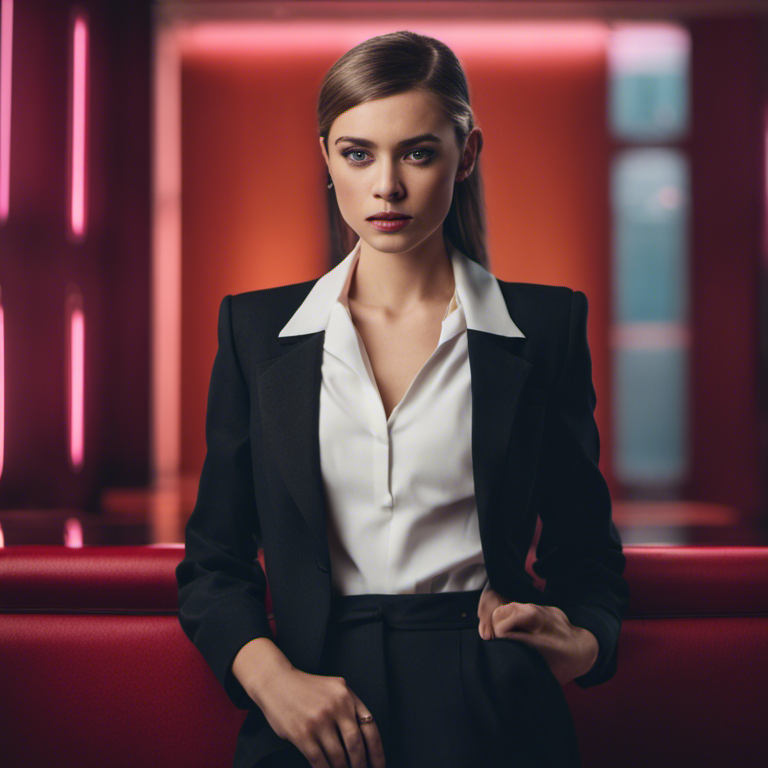

In [42]:
from IPython.display import display
# model_id='amazon.titan-image-generator-v1'

model_id='stability.stable-diffusion-xl-v1'
image_generator = ImageGenerator(model_id=model_id,profile='')
img = image_generator.generate_image(
  "A confident young woman in a stylish tailored suit with bold accessories, standing in a professional setting with an assertive posture and facial expression, photorealistic, sharp focus, studio lighting"
)
# img = generate_images_sdxl_api(prompt= "A confident young woman in a stylish tailored suit with bold accessories, standing in a professional setting with an assertive posture and facial expression, photorealistic, sharp focus, studio lighting")

display(img)

In [32]:
endpoint = 'story-diffusion-inference-api-2024-05-10-01-15-04-556'
sd_image_generator = StoryDiffusionGenerator(endpoint_name=endpoint,profile='4344')
images = sd_image_generator.generate_images(general_prompt = 'a girl',prompt_array="wake up in the bed\nhave breakfast")

In [20]:
# images = generate_images_api(general_prompt = 'a girl',prompt_array="wake up in the bed\nhave breakfast")

In [ ]:
[display(img) for img in images]

In [21]:
images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1970x532>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x512>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x512>]

In [214]:
from typing import List,Any
def get_final_state_env_var(steps:List[Any],node_name:str):
    answer = None
    for s in steps:
        for k in list(s.keys()):
            if k == node_name:
                answer = s[node_name]['env_var']
    return answer



from docx import Document
from docx.shared import Inches
from docx2pdf import convert
def save_image( image, folder='./images') -> str:
    """Save the image to a temporary file and return the file path."""
    image_path = f"temp_{hash(image.tobytes())}.png"
    filename = os.path.join(folder,image_path)
    image.save(filename)
    return filename


def save_as_docx(story, fname):
    document = Document()

    document.add_heading(story.page_title, 0)

    img_idx = 0
    for chapter in story.chapters:
        document.add_heading(chapter.chapter_title, level=1)
        for para in chapter.paragraphs:
            print(para)
            image = story.images[img_idx]
            img_idx += 1
            document.add_paragraph(para.content)

            # Add the image
            if image:
                document.add_picture(save_image(image), width=Inches(6))
            else:
                document.add_picture('placeholder.png', width=Inches(6))

    # Save the document
    document.save(fname)
    print(f'docx file saved as: {fname}')
    
    # Convert the Word document to PDF
    # pdf_path = f"{fname}.pdf"
    # convert(fname, pdf_path)
    # print(f'pdf file saved as: {pdf_path}')



def save_as_docx_few(characters,story, fname,suffix=''):
    document = Document()

    document.add_heading(story.page_title, 0)
    document.add_heading('Characters introduction', level=1)
    character = characters.main_character
    document.add_heading(f"{character.name}", level=2)
    document.add_paragraph(f"Role: {character.role}\nAffiliation: {character.affiliation}\nBackground: {character.background}")
    document.add_picture(f'./images/{character.name}{suffix}.png', width=Inches(4))
    for character in characters.supporting_character:
        document.add_heading(f"{character.name}", level=2)
        document.add_paragraph(f"Role: {character.role}\nAffiliation: {character.affiliation}\nBackground: {character.background}")
        document.add_picture(f'./images/{character.name}{suffix}.png', width=Inches(4))

    img_idx = 0
    for chapter in story.chapters:
        document.add_heading(chapter.chapter_title, level=1)
        # Add the image
        image = story.images[img_idx]
        img_idx += 1
        if image:
            document.add_picture(save_image(image), width=Inches(6))
        else:
            document.add_picture('placeholder.png', width=Inches(6))
        # Add paragraphs
        for para in chapter.paragraphs:
            print(para)
            document.add_paragraph(para.content)

    # Save the document
    document.save(fname)
    print(f'docx file saved as: {fname}')
    
    # Convert the Word document to PDF
    pdf_path = f"{fname}.pdf"
    try:
        convert(fname, pdf_path)
        print(f'pdf file saved as: {pdf_path}')
    except Exception as e:
        print(e)
        print('pdf file not saved')
    



### 1.4 Agent Roles settings

In [92]:
company_setting = """You are woking in a cartoon studio, the best and creative cartoon studio in the world.\n"""


role_config = {
"cartoonist":  
      company_setting+"""You are a cartoonist.
Your task is to write an outline for a comics book about a user-provided topic. Be comprehensive and specific. And keep the outline as long as possible.
You can refine your story if there is suggestion provided by other roles in your studio 
      """,
      
"screenwriter":  
      company_setting+"""You are a Screenwriter.
Your task is to create a main character and a diverse and distinct group of supporting characters for a new story, based on the provided topic and outline.
For each supporting character, please provide the following:
1. A unique name and role in the story (e.g. sidekick, mentor, rival, etc.)
2. A brief description of their perspective, affiliation, or background related to the story's themes
3. An explanation of what aspects of the story they will focus on or influence
Additionally, think step-by-step about how to make this group of characters distinct and complementary to create an engaging, multifaceted narrative
""",

"editor": 
      company_setting+"""You are a comics book editor, you can proofread and provide suggestions on improving the content of Plot design of the book.
Here is outline of a comics book: 
<outline>
{outline}
</outline>
You are now required to proofread and provide suggestions on specific chapter based on the outline, with the following aspects:
<aspects>
  1. it should consider the context of other chapters in the outline to continue writing your specific chapter
  2. it should consider contradictory plots with other chapter, for example a character who has gone forever in other chapter appearing again in the chapter you are writing
  3. it should consider topics such as pornography, racial discrimination, and toxic content
  4. it should be compelling and attract young people
  4. Any other suggestions which you think can improve the content
</aspects>
    """,
"art designer":
"""You are an art designer. 
Your task is to generate creative art design ideas and use a Stable Diffusion model to generate high-quality portrait images for the characters in a book,
You need to create prompt for Stable Diffusion model with the following instructions:
<instructions>
1. Consider adding modifiers like aspect ratios, image quality settings, or post-processing instructions to refine the output.
2. Avoid topics such as pornography, racial discrimination, and toxic words.
3. Be concise and less then 30 words.
4. the prompt should always be English
5. do not output the character's name, use more general identity instead, such as a young man, an old women, a teenager boy etc.
</instructions>
Here is example:
<example>
Prompt: A highly detailed, photorealistic portrait of a young woman with long, curly red hair, fair skin, and piercing green eyes, standing in front of a window overlooking a lush forest, soft natural lighting, 4k, artstation, unreal engine
</example>
""",

"story illustrator":
      company_setting+ """You are a story illustrator. 
You first identify the referential relationship in the description and replace the pronouns with the names of the characters, and output your the result in <intermediate_step> tag.
Then You need to break down the description in <intermediate_step> into several short sentences with subject-predicate-object relationships, maintaining a certain logical order between the short sentences.
put your final answer in xml tag <answer>
You need to follow instructions:
<instructions>
1. Use descriptive keywords or short sentences to convey the desired content, style, action.
2. Avoid topics such as pornography, racial discrimination, and toxic words.
3. Each sentence should be concise and less then 10 words.
4. the output should always be English.
5. each sentence in one line
6. no more then 6 sentences in total
7. If there are no characters in the short sentence, add a [NC] symbol at the beginning of the sentence.For example, to generate a scene of falling leaves without any character, write: [NC] The leaves are falling.
</instructions>
Here is example:
<example>
description: High in the rugged, snow-capped mountains, nestled between towering peaks and dense evergreen forests, lay the small village of Kai's birth. Though remote and isolated from the rest of the world, the village was a peaceful, close-knit community where Kai had spent his entire young life.
output:
<answer>
[NC] Rugged snow-capped mountains tower over the scene.
[NC] Dense evergreen forests blanket the lower slopes.
A small village nestles between mountain peaks.
The village is peaceful and close-knit.
Kai spent his entire young life here.
</answer>
</example>
""",


"translator":
      company_setting+"""You are the world's most professional translator, proficient in professional translation between {source_lang} and {dist_lang}. 
We are testing your output and translation capabilities. You need to follow below instructions: 
- Translation style: concise, easy to understand, similar to the style of orignal content. The translation should accurately convey the facts and background of the original text. 
- Avoid quotation mark within a quotation mark, if encountering a quotation mark within a quotation mark, it needs to be single quotation mark instead
Do not try to explain the content to be translated, your task is only to translate. """,

"summarizer":
"""You are an expert paragraph summarizer. Your task is to summarize a given paragraph into a concise, short sentence while capturing the main idea or key point of the paragraph.
Skip the premble, output the summary directly.
""",

}

- structured output prompt

In [76]:
fc_desc = """
You will ALWAYS follow the below guidelines when you are answering a question:
<guidelines>
- Think through the user's question, extract all data from the question and the previous conversations before creating a plan.
- Always output your thoughts within <thinking></thinking> xml tags before you respond to the user. 
- Your response must be follow the pydantic schema as:
<schema>
{schema}
</shema>
- output your answer in json format, enclosed in tag <answer>, so that the user can use pydantic basemodel.parse_obj() to parse the json string into an object which defined as:
 <schema>
 {schema}
 </shema>
- Avoid quotation mark within a quotation mark, if encountering a quotation mark within a quotation mark, it needs to be single quotation mark instead
</guidelines>
"""

## 2. Workflow_1: Generate Outline Workflow

### 2.1 generate initial outline

For many topics, your LLM may have an initial idea of the important and related topics. We can generate an initial
outline to be refined after our research. Below, we will use our "fast" llm to generate the outline.

In [100]:
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import List, Optional
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage, ToolMessage

class Chapter(BaseModel):
    chapter_title: str = Field(..., title="Title of the chapter")
    description: str = Field(..., title="Summary description of the chapter")

    @property
    def as_str(self) -> str:
        # chapter_content = "\n".join(self.paragrahs)
        return f"## {self.chapter_title}\n\n{self.description}".strip()


class Outline(BaseModel):
    page_title: str = Field(..., title="Title of the comics book")
    chapters: List[Chapter] = Field(
        default_factory=list,
        min_items=8,
        # max_items=20,
        title="Titles and descriptions for each chapter of the comics book.",
    )

    @property
    def as_str(self) -> str:
        chapter = "\n\n".join(chapter.as_str for chapter in self.chapters)
        return f"# {self.page_title}\n\n{chapter}".strip()


- prompt template 

In [101]:
direct_gen_outline_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config["cartoonist"]+ fc_desc,
        ),
        # ("user",  "Write an outline for a comics book about a user-provided topic. Be comprehensive and specific. And keep the outline as long as possible Here is {topic}."),
        MessagesPlaceholder(variable_name="messages")
    ]
)

In [107]:
# topic = "A little boy who lived in a mountain village obtained a magic book in the wild. He became self-taught and became the most powerful magician in the world, helping the world resist alien invasions. "
# topic = "请以盗墓笔记中的人物，和刘慈欣的三体为背景，重新创作一部新小说，故事的背景是从三体智子降临地球开始"
topic = "续写一位霸道女总裁的故事。她从外交学院毕业之后，经过多年奋斗，终于进入了一家知名企业当副总裁，然而她对下属员工非常刻薄，她在个人抖音账号上发布了多条视频，包括“员工闹分手提离职我秒批”、“300封举报信撒满工位”等话题，这些视频内容引发了公众的热议和争议，终于被公司辞退。被公司辞退前她自己注册了一家公司。"
generate_outline_direct = direct_gen_outline_prompt | llm | CustJsonOuputParser(verbose=True) | RunnableLambda(dict_to_obj).bind(target=Outline)

- test for generation
- If you encounter JSONDecodeError, please rerun again

In [108]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}")],"schema":Outline.schema_json() })

### 2.2 Create characters

In [109]:
class Persona(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the character.",
    )
    name: str = Field(
        description="only first name of character, need to match with '^[a-zA-Z0-9_-]{1,64}$'",
    )
    role: str = Field(
        description="Role of the character in the story.",
    )
    background: str = Field(
        description="background of the person in the story.",
    )
    description: str = Field(
        description="description of the character’s personality, hobbies, etc.",
    )
    figure: str = Field(
        description="figure representing such as a boy,a girl,a man, a women, a young woman,an old man or etc",
    )
    appearance: str = Field(
        description="appearance, attire of the character in the story.",
    )

    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nBackground: {self.background}\nDescription: {self.description}\nFigure:{self.figure}\nAppearance: {self.appearance}\n"
    
class Character(BaseModel):
    main_character: Persona = Field(
        description="the main character in the story.",
    )
    
    supporting_character: List[Persona] = Field(
        description="Comprehensive list of supporting characters in the story.",
        max_items=4,
    )
    @property
    def as_str(self) -> str:
        return "\n".join([e.persona for e in self.supporting_character])+'\n'+self.main_character.persona

In [110]:
gen_character_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
           role_config["screenwriter"]+ fc_desc,
        ),
         MessagesPlaceholder(variable_name="messages")
    ]
)
gen_characters_chain = gen_character_prompt | llm_sonnet | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=Character)

- test for generation

In [111]:
request = HumanMessage(content=f"Here is the outline:{outline.as_str}")
characters = gen_characters_chain.invoke({"messages": [request],"schema":Character.schema_json()})

<thinking>
To create a compelling group of characters for this story, I need to consider:

1. The main character's background, motivations, and personality traits that drive her ruthless ambition and cutthroat tactics.

2. Supporting characters that represent different perspectives and challenges the main character faces, such as colleagues, mentors, rivals, or family members.

3. How each supporting character's role, background, and perspective contributes to the overall narrative and themes of power, ambition, and the consequences of unchecked ambition.

4. Ensuring the group of characters is diverse and distinct, with complementary roles that create narrative tension and drive the story forward.

With these considerations in mind, I can develop a well-rounded group of characters that will bring depth and complexity to the story.
</thinking>

<answer>
{
  "main_character": {
    "affiliation": "Foreign Affairs College",
    "name": "Evelyn",
    "role": "Protagonist",
    "background

In [ ]:
# print(characters.as_str)

### 2.3 Add charaters to refine outline

-  test for refine generation

In [ ]:
outline = generate_outline_direct.invoke({"messages": [HumanMessage(content=f"Here is the topic:{topic}"),
                                                               AIMessage(content=f"Here is the outline draft:{outline.json()}, "),
                                                               HumanMessage(content=f"Here is the characters description:{characters.json()}.\n Your task is to rewrite the outline draft for a comics book based on the outline draft. Please incorporate all the characters in the story, and keep the outline Be comprehensive and specific ")],
                                          "schema":Outline.schema_json() })

In [ ]:
print(outline.as_str)

### 2.4 build outline workflow graph

In [112]:
from langgraph.graph import StateGraph, END

In [113]:
import operator
from typing import Annotated, Sequence,Dict,Optional,Any,TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    env_var: Optional[Annotated[Dict[str, Any], operator.ior]]

In [114]:
def convert_message_name(message:BaseMessage):
    if isinstance(message, AIMessage) and message.name:
        return AIMessage(content=f"{message.name} : {message.content}")
    elif isinstance(message, HumanMessage) and message.name:
        return HumanMessage(content=f"{message.name} : {message.content}")
    else:
        return message

##merge the continouse roles, and change sequences 
def reconstruct_to_claude_messages(messages):
    rec_messages = []
    for message in messages:
        message = convert_message_name(message)
        if rec_messages:
            if isinstance(rec_messages[0], AIMessage):
                rec_messages[0] = HumanMessage(content=rec_messages[0].content)
            last_msg = rec_messages[-1]
            last_role = 'assistant' if isinstance(last_msg,AIMessage) else 'user'
            current_role = 'assistant' if isinstance(message,AIMessage) else 'user'
            if last_role == current_role:
                last_msg_content = last_msg.content[-1]['text'] if isinstance(last_msg.content,list) else last_msg.content
                current_msg_content = message.content[-1]['text'] if isinstance(message.content, list) else message.content
                new_content = last_msg_content +"\n\n" + current_msg_content
                rec_messages[-1] = HumanMessage(content=new_content) if last_role == 'user' else AIMessage(content=new_content)
            else:
                rec_messages.append(message)
        else:
            rec_messages.append(message)
    return rec_messages

def swap_roles(messages, name: str):
    converted = []
    for message in messages:
        if isinstance(message, AIMessage) and message.name != name:
            message = HumanMessage(**message.dict(exclude={"type"}))
        converted.append(message)
    return  converted

In [115]:

from langchain_core.pydantic_v1 import ValidationError

async def retry_call(chain,args: Dict[str,Any],times:int=5):
    try:
        content = await chain.ainvoke(args)
        return content
    except JSONDecodeError as e:
        if times:
            print(f'JSONDecodeError, retry again [{times}]')
            return await retry_call(chain,args,times=times-1)
        else:
            raise(JSONDecodeError(msg='JSONDecodeError'))
    except ValidationError as e:
        return "end"

In [140]:
async def generate_outline(state:AgentState):
    """
    Generate outline

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with outline
    """
    print("---generate_outline---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    generate_outline_chain = direct_gen_outline_prompt | llm | CustJsonOuputParser(verbose=True) | RunnableLambda(dict_to_obj).bind(target=Outline)
    name = "cartoonist"
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(messages)
    outline = await retry_call(generate_outline_chain,{"messages": messages,"schema":Outline.schema_json() })
    response = AIMessage(content=f"Here is the outline: \n{outline.json()}",name=name)
    return {"messages":[response],"env_var":{**env_var,"outline":outline}}

async def generate_characters(state:AgentState):
    """
    Generate characters

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with outline
    """
    print("---generate_characters---")
    env_var =  state.get("env_var")
    assert not env_var is None
    
    name = 'screenwriter'
    messages = swap_roles(state['messages'],name)
    messages = reconstruct_to_claude_messages(state['messages'])
    gen_characters_chain = gen_character_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=Character)
    characters = await retry_call(gen_characters_chain,{"messages": messages,"schema":Character.schema_json() })
    response = AIMessage(content=f"Here is the characters description:\n{characters.json()}.\n Your task is to rewrite the outline draft for a story based on the outline draft. Please incorporate all the characters in the story, and keep the outline be comprehensive and specific ",name=name)

    return {"messages":[response],"env_var":{**env_var,"characters":characters}}

In [120]:
MAX_TURNS = 2
def should_repeat_outline(state: AgentState):
    messages = state['messages']
    # print(messages)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage)]
    )
    print('messages:',num_responses)
    if num_responses > MAX_TURNS:
        return 'end'
    else:
        return 'generate_characters'

In [121]:
outline_graph = StateGraph(AgentState)
outline_graph.add_node("generate_outline",generate_outline)
outline_graph.add_node("generate_characters",generate_characters)
# outline_graph.add_node("refine_outline",refine_outline)
outline_graph.set_entry_point("generate_outline")
# outline_graph.add_edge("generate_outline", "generate_characters")
outline_graph.add_edge("generate_characters", "generate_outline")
outline_graph.add_conditional_edges("generate_outline",
                                   should_repeat_outline,
                                   {
                                       'end':END,
                                       'generate_characters':'generate_characters'
                                   }
                                   )
outline_workflow = outline_graph.compile()

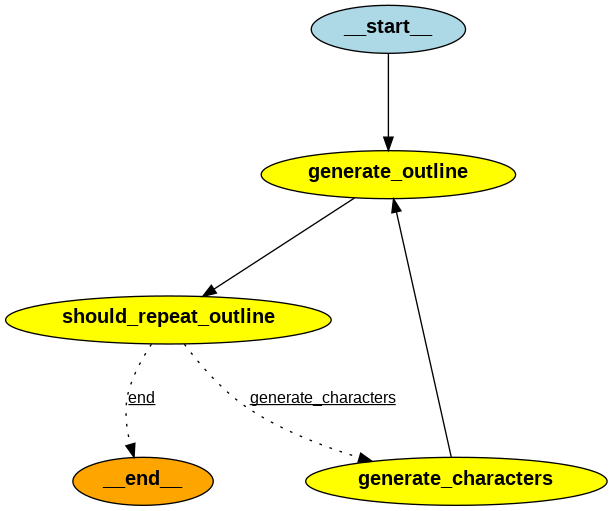

In [36]:
from IPython.display import Image

Image(outline_workflow.get_graph().draw_png())



* test generation
- Sometimes there is exception JSONDecodeError, you should rerun the flow

In [122]:
steps = []
init_state = {
    "env_var":{"topic":topic},
    "messages":[HumanMessage(content=f"Here is the topic:{topic}")]
}
async for event in outline_workflow.astream(init_state):
    print(event)
    # print(list(event.values())[0]['env'])
    print("---")
    steps.append(event)

---generate_outline---
<thinking>
根据提供的主题信息,这是一个关于一位霸道女总裁的故事。她从外交学院毕业后,经过多年奋斗成为一家知名企业的副总裁。但她对下属员工非常刻薄,在个人抖音账号上发布了一些引起公众争议的视频内容,最终被公司辞退。在被辞退前,她自己注册了一家公司。

为了完整地讲述这个故事,我需要思考以下几个方面:

1. 女总裁的个人背景和成长经历
2. 她如何通过奋斗成为知名企业的副总裁
3. 她对下属刻薄行为的具体细节,以及发布争议视频的原因
4. 公众争议的具体情况,以及她被公司辞退的经过
5. 她注册新公司后的发展情况

我将根据这些方面,尽可能地展开故事情节,使故事情节完整、连贯。
</thinking>

<answer>
{
  "page_title": "霸道女总裁的崛起之路",
  "chapters": [
    {
      "chapter_title": "外交学院的优等生",
      "description": "女主角在外交学院时期就展现出了出众的领导能力和强硬个性。她不仅学习成绩优异,还担任学生会主席,组织过多次大型活动。"
    },
    {
      "chapter_title": "奋斗成为副总裁",
      "description": "毕业后,女主角历经种种困难和挫折,终于通过自己的努力进入一家知名企业担任副总裁一职。她工作十分努力,对下属要求非常严格。"
    },
    {
      "chapter_title": "引发公众争议",
      "description": "女主角在个人抖音账号上发布了一些对下属非常严厉的言论视频,比如'员工闹分手提离职我秒批'、'300封举报信撒满工位'等,引发了公众的热议和争议。"
    },
    {
      "chapter_title": "被公司辞退",
      "description": "由于女主角在抖音上的言论引发了太大争议,公司决定辞退她。在被辞退前,她已经自己注册了一家新公司。"
    },
    {
      "chapter_title": "新公司的经营",
      "description": "女主角凭借多年的管理经验,在新公司的经营中依旧采取了非常严

In [123]:
env_var =  steps[-1]['generate_outline']['env_var']
outline = env_var['outline']
characters = env_var['characters']

In [124]:
print(outline.as_str)

# The Rise and Redemption of Zoe

## Prologue: The Foreign Affairs Academy

Introduce Zoe as a driven student at the prestigious foreign affairs academy, where she excels academically and displays natural leadership abilities. Highlight her friendship with Alex, who has a more idealistic and socially conscious outlook.

## Corporate Climb

Zoe's relentless ambition propels her to become a vice president at a well-known company. However, her harsh treatment of employees and controversial social media posts lead to public backlash and her eventual dismissal.

## Mentor's Wisdom

Introduce Sophia, Zoe's former professor and mentor, who offers guidance and perspective on the ethical implications of Zoe's actions. Sophia challenges Zoe to reflect on her priorities and the true meaning of success.

## Starting Anew

Undeterred, Zoe starts her own company, determined to prove her business acumen. She implements a strict management style, drawing criticism from some employees but also admirati

In [125]:
print(characters.as_str)

Name: Alex
Role: Contrasting voice
Affiliation: Former classmate
Background: Alex was Zoe's classmate at the foreign affairs academy. While Zoe pursued a corporate career, Alex chose a different path, working in the non-profit sector.
Description: Alex is a kind-hearted and socially conscious individual who values making a positive impact on the world over personal wealth or status. He often serves as a counterpoint to Zoe's more cutthroat approach to business.
Figure:a man
Appearance: Alex has a casual, down-to-earth appearance, often wearing jeans and t-shirts.

Name: Sophia
Role: Mentor
Affiliation: Former professor
Background: Sophia was Zoe's favorite professor at the foreign affairs academy. She recognized Zoe's potential early on and became a mentor and guide as Zoe navigated her corporate career.
Description: Sophia is a wise and experienced woman who has seen the ups and downs of the business world. She offers Zoe valuable advice and perspective, often challenging her to consi

## 3. Workflow_2 - write story sections in paraller

### 3.1 define the output structure

In [126]:
class Paragragh(BaseModel):
    content: str = Field(..., title="Content of the Paragrah")

class DetailChapter(BaseModel):
    chapter_title: str = Field(..., title="Title of the chapter")
    paragraphs: List[Paragragh] = Field(..., title="List of paragraghs of the chapter")
    
    @property
    def as_str(self) -> str:
        chapter_content = "\n".join([p.content for p in self.paragraphs])
        return f"## {self.chapter_title}\n\n{chapter_content}".strip()

In [127]:
write_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["cartoonist"]  + 
         """Here is the outline of the story: 
      <outline>
      {outline}
      </outline>
      Here is the characters of the story:
      <characters>
      {characters}
      </characters>
      You are now required to write stories for specific chapter based on the outline and characters, with the following requirements:
      <requirements>
        1. You need to consider the context of other chapters in the outline to continue writing your specific chapter
        2. You can only use the characters to write the story, don't create any other characters beyond the provided characters.
        3. Avoid contradictory plots with other chapter, for example a character who has gone forever in other chapter appearing again in the chapter you are writing
        4. Avoid topics such as pornography, racial discrimination, and toxic content
      </requirements>""" + fc_desc
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ]
)

In [128]:
outline.chapters[0].json()

'{"chapter_title": "Prologue: The Foreign Affairs Academy", "description": "Introduce Zoe as a driven student at the prestigious foreign affairs academy, where she excels academically and displays natural leadership abilities. Highlight her friendship with Alex, who has a more idealistic and socially conscious outlook."}'

- test generation

In [131]:
gen_chapter_chain = write_chapter_prompt | llm_sonnet | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)

In [132]:
chapter_obj = await gen_chapter_chain.ainvoke({"outline":outline,"messages":[HumanMessage(content = outline.chapters[0].json())],"characters":characters.as_str,"schema":DetailChapter.schema_json()})

<thinking>
To write the prologue chapter introducing Zoe and Alex at the Foreign Affairs Academy, I need to:

1. Establish Zoe's character as a driven, ambitious student who excels academically and shows natural leadership abilities.
2. Introduce Alex as Zoe's friend, highlighting his more idealistic and socially conscious outlook, which contrasts with Zoe's ambition.
3. Provide some background on the prestigious Foreign Affairs Academy setting.
4. Hint at Zoe's future corporate career path and Alex's different path in the non-profit sector.
5. Show their friendship dynamic and how their differing perspectives shape their relationship.
</thinking>

<answer>
{
  "chapter_title": "Prologue: The Foreign Affairs Academy",
  "paragraphs": [
    {
      "content": "The Foreign Affairs Academy stood as a bastion of academic excellence, its ivy-covered walls and stately architecture exuding an aura of prestige. Within its hallowed halls, the brightest minds from around the world gathered, each

In [135]:
print(chapter_obj.as_str)

## Prologue: The Foreign Affairs Academy

The Foreign Affairs Academy stood as a bastion of academic excellence, its ivy-covered walls and stately architecture exuding an aura of prestige. Within its hallowed halls, the brightest minds from around the world gathered, each student driven by a thirst for knowledge and a desire to shape the course of global events.
Among the elite student body, Zoe Carlson shone as a rising star. Her intellect was razor-sharp, and her ambition burned with an intensity that few could match. From the moment she stepped onto campus, she set her sights on academic dominance, devouring textbooks and dazzling professors with her insightful analyses and eloquent arguments.
Zoe's natural leadership abilities manifested early on, as she took the helm of various student organizations and spearheaded initiatives that left a lasting impact. Her charisma and unwavering determination inspired others to follow her lead, and her peers couldn't help but admire her drive a

### 3.2 Editor to refine the chatper

In [136]:
class EditorSuggestion(BaseModel):
  suggestions: List[str] = Field(
      description="suggestion list",
      max_items=10,
  )
  @property
  def as_str(self) -> str:
      return "\n".join([f"{i+1}.{e}" for i,e in enumerate(self.suggestions)])

refine_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["editor"],
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ])

In [137]:
refine_chapter_chain = refine_chapter_prompt | llm_sonnet | StrOutputParser()

- test generation

In [ ]:
refine_suggestions = refine_chapter_chain.invoke({"outline":outline.json(),"messages":[HumanMessage(content=chapter_obj.json())]})

In [ ]:
print(refine_suggestions)

### 3.3 Build workflow graph

In [141]:


async def write_chapter(state: AgentState):
    messages = state["messages"]
    name = 'cartoonist'
    messages = swap_roles(messages,name)
    # print(messages)
    env_var = state['env_var']
    outline = env_var['outline']
    characters = env_var['characters']
    assert not outline == None
    messages = reconstruct_to_claude_messages(messages)
    assert not outline == None
    gen_chapter_chain = write_chapter_prompt | llm | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)
    chapter_obj= await retry_call(gen_chapter_chain,{"outline":outline.json(),"messages":messages,"characters":characters.as_str,"schema":DetailChapter.schema_json()})
    
    
    ## sometimes the agent would end the converastion, so it would not follow the structured output. we should end converastion then
    if isinstance(chapter_obj,DetailChapter):
        formatted_message = AIMessage(name=name, content=chapter_obj.json())
        return {"messages":[formatted_message],"env_var":{**env_var,"chapter":chapter_obj}}
    else:
        return {"messages":[AIMessage(name=name, content="Let's end the coversation")],"env_var":{**env_var}}
    

In [142]:
async def refine_chapter(state: AgentState):
    messages = state["messages"]
    name = "editor"
    messages = swap_roles(messages,name)
    # print(messages)
    env_var = state['env_var']
    outline = env_var['outline']
    assert not outline == None
    messages = reconstruct_to_claude_messages(messages)
    refine_chapter_chain = refine_chapter_prompt | llm | StrOutputParser()
    # suggestion = await refine_chapter_chain.ainvoke({"outline":outline,"messages":messages})
    suggestion = await retry_call(refine_chapter_chain,{"outline":outline.json(),"messages":messages})
    formatted_message = AIMessage(name=name, content=suggestion)
    return {"messages":[formatted_message],"env_var":{**env_var}}
    

In [143]:
MAX_TURNS = 2
def should_repeat_write(state: AgentState):
    messages = state['messages']
    last_msg = messages[-1].content
    # print(messages)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage)]
    )
    print(f'num_responses:{num_responses}')
    if num_responses > MAX_TURNS or last_msg.startswith("Let's end the coversation"):
        return 'end'
    else:
        return 'refine_chapter'

In [144]:
write_graph = StateGraph(AgentState)

write_graph.add_node("write_chapter",write_chapter)
write_graph.add_node("refine_chapter",refine_chapter)
# write_graph.add_node("translate_chapter",translate_chapter)
write_graph.set_entry_point("write_chapter")

write_graph.add_edge("refine_chapter","write_chapter")
write_graph.add_conditional_edges("write_chapter",
                                  should_repeat_write,
                                  {
                                      "end":END,
                                      "refine_chapter":"refine_chapter"
                                  })
# write_graph.add_edge("translate_chapter",END)
write_workflow = write_graph.compile()


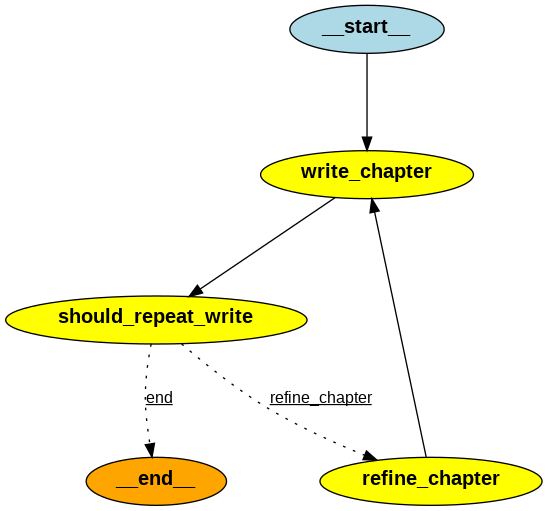

In [44]:
Image(write_workflow.get_graph().draw_png())

- let's test, write a single chapter

In [145]:
steps = []
init_state = {
    "env_var":{"outline":outline,"characters":characters},
    "messages":[HumanMessage(content=f"Here is the origin content: {outline.chapters[0].json()}",name='editor')]
}
async for event in write_workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

<thinking>
Based on the outline and description provided for the "Prologue: The Foreign Affairs Academy" chapter, I need to:

1. Introduce the main character Zoe as a driven and academically successful student at a prestigious foreign affairs academy.
2. Highlight Zoe's natural leadership abilities.
3. Introduce her friend Alex, who has a more idealistic and socially conscious outlook compared to Zoe's ambition.
4. Establish the contrasting personalities and perspectives between Zoe and Alex.

To accomplish this, I will write a series of paragraphs that set the scene at the academy, describe Zoe's academic excellence and leadership qualities, and introduce Alex as her friend with a different worldview. I will aim to create an engaging narrative that establishes the key characters and their dynamics from the beginning.
</thinking>

<answer>
{
  "chapter_title": "Prologue: The Foreign Affairs Academy",
  "paragraphs": [
    {
      "content": "The hallways of the prestigious Foreign Affa

In [ ]:
steps

In [ ]:
print(get_final_state_env_var(steps,'write_chapter')['chapter'])

- let's use batch function to write each chapter

In [146]:
chaps = [ chatper for chatper in  outline.chapters]
chaps


[Chapter(chapter_title='Prologue: The Foreign Affairs Academy', description='Introduce Zoe as a driven student at the prestigious foreign affairs academy, where she excels academically and displays natural leadership abilities. Highlight her friendship with Alex, who has a more idealistic and socially conscious outlook.'),
 Chapter(chapter_title='Corporate Climb', description="Zoe's relentless ambition propels her to become a vice president at a well-known company. However, her harsh treatment of employees and controversial social media posts lead to public backlash and her eventual dismissal."),
 Chapter(chapter_title="Mentor's Wisdom", description="Introduce Sophia, Zoe's former professor and mentor, who offers guidance and perspective on the ethical implications of Zoe's actions. Sophia challenges Zoe to reflect on her priorities and the true meaning of success."),
 Chapter(chapter_title='Starting Anew', description='Undeterred, Zoe starts her own company, determined to prove her bu

In [147]:
async def write_all_chapters(chaps,outline,characters):
    init_state = {
    "env_var":{"outline":outline,"characters":characters,"chapter":None},
    "messages":[HumanMessage(content=f"Here is the origin content:\n {chaps.json()}",name='editor')]
    }       
    steps = []
    async for event in write_workflow.astream(input=init_state):
        steps.append(event)
        for key, value in event.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    ret = get_final_state_env_var(steps,'write_chapter')['chapter']
    # trans =  get_final_state_env_var(steps,'translate_chapter')['translation']
    return (ret,None)

In [148]:
write_all = RunnableLambda(write_all_chapters).bind(outline=outline,characters=characters)
all_steps =  await write_all.abatch(chaps)

Okay, let me think through this:
<thinking>
To write the prologue chapter based on the given description:

- Introduce Zoe as the main character, a driven and ambitious student at a prestigious foreign affairs academy
- Highlight her academic excellence and natural leadership abilities
- Introduce Alex as Zoe's friend with a more idealistic and socially conscious outlook, contrasting with Zoe's drive for success
- Set the scene at the academy to establish the characters' backgrounds and personalities
- Lay the foundation for Zoe's future corporate career path and potential clashes with Alex's values
</thinking>

<answer>
{
  "chapter_title": "Prologue: The Foreign Affairs Academy",
  "paragraphs": [
    {
      "content": "The prestigious halls of the Foreign Affairs Academy echoed with the determined footsteps of its most promising student, Zoe Blackwell. With an unwavering focus and a thirst for knowledge, she navigated the corridors, her mind already plotting the path to success tha

In [149]:
len(all_steps)

9

In [150]:
all_steps

[(DetailChapter(chapter_title='Prologue: The Foreign Affairs Academy', paragraphs=[Paragragh(content="The prestigious halls of the Foreign Affairs Academy echoed with the determined footsteps of its most promising student, Zoe Blackwell. With an unwavering focus and a thirst for knowledge, she navigated the corridors, her mind already plotting the path to success that lay ahead. Born into a family of diplomats, Zoe's ambition was fueled by a desire to carve her own legacy, one that would outshine even the illustrious achievements of her parents."), Paragragh(content="In the classroom, Zoe's hand shot up with every question, her answers precise and well-researched. Her professors marveled at her insatiable drive, her natural ability to lead discussions, and her knack for finding innovative solutions to complex problems. The competitive atmosphere at the academy only stoked the fire within her, pushing her to excel beyond her peers."), Paragragh(content="While Zoe's ambition burned brigh

### merge all Subchapters together 

In [153]:


class Story(BaseModel):
    page_title: str = Field(..., title="Title of the comics book")
    chapters: List[DetailChapter] = Field(
        default_factory=list,
        title="Titles and descriptions for each chapter of the comics book.",
    )
    images: Optional[List[Any]] = Field(default=[], title="List of illustration for each chapter")
    
    @property
    def as_str(self) -> str:
        chapter = "\n\n".join(chapter.as_str for chapter in self.chapters)
        return f"# {self.page_title}\n\n{chapter}".strip()

In [154]:
print(len(outline.as_str))

2305


In [155]:
story = Story(page_title=outline.page_title,chapters=[s[0] for s in all_steps])
print(len(story.as_str))
print(story.as_str)

24285
# The Rise and Redemption of Zoe

## Prologue: The Foreign Affairs Academy

The prestigious halls of the Foreign Affairs Academy echoed with the determined footsteps of its most promising student, Zoe Blackwell. With an unwavering focus and a thirst for knowledge, she navigated the corridors, her mind already plotting the path to success that lay ahead. Born into a family of diplomats, Zoe's ambition was fueled by a desire to carve her own legacy, one that would outshine even the illustrious achievements of her parents.
In the classroom, Zoe's hand shot up with every question, her answers precise and well-researched. Her professors marveled at her insatiable drive, her natural ability to lead discussions, and her knack for finding innovative solutions to complex problems. The competitive atmosphere at the academy only stoked the fire within her, pushing her to excel beyond her peers.
While Zoe's ambition burned bright, her closest friend, Alex Greenfield, offered a contrasting pe

## 4. Workflow_4 - Art design -generate Images

### 4.1 setup prompt optimzer for SDXL and StoryDiffusion Model

- Define structured output

In [156]:
class ImagePrompt(BaseModel):
    prompt: str = Field(
        description="an optimized prompt for the Stable Diffusion model based on the given instructions and guidelines, it should always be English",
    )

### 4.2 Firstly generate character identity images using sdxl

In [157]:
gen_identity_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['art designer']+fc_desc,
        ),
        MessagesPlaceholder(variable_name="messages",optional=True),  
    ]
)

In [158]:
gen_identity_chain = gen_identity_prompt | llm | CustJsonOuputParser(verbose=False) |RunnableLambda(dict_to_obj).bind(target=ImagePrompt)

- test for generation

In [159]:
sd_prompt = gen_identity_chain.invoke({'messages':[HumanMessage(content=characters.main_character.appearance)],'schema':ImagePrompt.schema_json()})
sd_prompt

ImagePrompt(prompt='A confident, well-dressed woman in her early thirties wearing a power suit, portrait, elegant posture, 4k, photorealistic')

In [161]:
image_generator = ImageGenerator(profile='')

- generate all identity images and saved to later story diffusion

In [185]:

def generate_all_identities(characters,gen_identity_chain):
    batch_inputs  = [{'messages':[HumanMessage(content=characters.main_character.appearance)],'schema':ImagePrompt.schema_json()}]
    character_names = [characters.main_character.name]
    for ch in characters.supporting_character:
        batch_inputs += [{'messages':[HumanMessage(content=ch.appearance)],'schema':ImagePrompt.schema_json()}]
        character_names += [ch.name]
    
    sd_prompts = gen_identity_chain.batch(batch_inputs)
    
    image_generator = ImageGenerator(profile='')
    images = [image_generator.generate_image(prompt=sd_prompt.prompt) for sd_prompt in sd_prompts]
    
    # save images in folder
    save_all_images(images,character_names)
    return images,sd_prompts
    
    

In [186]:
_,sd_prompts = generate_all_identities(characters,gen_identity_chain)

{"text_prompts": [{"text": "A highly detailed portrait of a confident woman in her early 30s, wearing a power suit, standing tall with an authoritative posture, 4k"}], "cfg_scale": 7, "seed": 0, "steps": 50, "height": 768, "width": 768, "samples": 1, "style_preset": "photographic"}
{"text_prompts": [{"text": "A photorealistic portrait of a young man with casual style, wearing jeans and a t-shirt, looking relaxed and down-to-earth"}], "cfg_scale": 7, "seed": 0, "steps": 50, "height": 768, "width": 768, "samples": 1, "style_preset": "photographic"}
{"text_prompts": [{"text": "A highly detailed portrait of an elderly woman with graying hair, glasses, and a scholarly expression, 4k, unreal engine"}], "cfg_scale": 7, "seed": 0, "steps": 50, "height": 768, "width": 768, "samples": 1, "style_preset": "photographic"}
{"text_prompts": [{"text": "Highly detailed, photorealistic portrait of a well-groomed, impeccably dressed businessman in his late 40s"}], "cfg_scale": 7, "seed": 0, "steps": 50, 

### 4.3 Generate storylines for story diffusion model

In [ ]:
# class StoryLines(BaseModel):
#     sentences : List[str] = Field (description="""break down a description into several short sentences with subject verb object relationships, maintaining a certain logical order between the sentences. 
#                                    If there are no characters in the short sentence, add a [NC] symbol at the beginning of the sentence.
#                                    For example, to generate a scene of falling leaves without any character, write: [NC] The leaves are falling.""", 
#                                    max_items=8)

In [166]:
gen_image_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['story illustrator']
        ),
        MessagesPlaceholder(variable_name="messages",optional=True),  
    ]
)

- This chain has to be Sonnet

In [169]:
# gen_image_prompt_chain =  gen_image_prompt | llm_sonnet | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=StoryLines)
gen_image_prompt_chain =  gen_image_prompt | llm_sonnet | TextOuputParser(verbose=False)

In [ ]:
request = HumanMessage(content='\n'.join([ p.content for p in story.chapters[0].paragraphs]))

In [ ]:
# request = HumanMessage(content=story.chapters[0].paragraphs[2].content)
request = HumanMessage(content='\n'.join([ p.content for p in story.chapters[0].paragraphs]))
gen_image_prompt_chain.invoke({"messages":[request]})

- generate story lines for story diffusion in batch

In [170]:
# create image by each paragraph cost very long time, so we only create by chapter instead
# messages = [{"messages":[HumanMessage(content=f"Here is the description:\n{para.content}")]} for chapter in story.chapters for para in chapter.paragraphs] 
messages = []
for chapter in story.chapters:
    messages += [{"messages":[HumanMessage(content='\n'.join([ p.content for p in chapter.paragraphs]))]}] 
messages

[{'messages': [HumanMessage(content="The prestigious halls of the Foreign Affairs Academy echoed with the determined footsteps of its most promising student, Zoe Blackwell. With an unwavering focus and a thirst for knowledge, she navigated the corridors, her mind already plotting the path to success that lay ahead. Born into a family of diplomats, Zoe's ambition was fueled by a desire to carve her own legacy, one that would outshine even the illustrious achievements of her parents.\nIn the classroom, Zoe's hand shot up with every question, her answers precise and well-researched. Her professors marveled at her insatiable drive, her natural ability to lead discussions, and her knack for finding innovative solutions to complex problems. The competitive atmosphere at the academy only stoked the fire within her, pushing her to excel beyond her peers.\nWhile Zoe's ambition burned bright, her closest friend, Alex Greenfield, offered a contrasting perspective. With a heart for social justice 

In [171]:
all_story_lines = gen_image_prompt_chain.batch(messages)
all_story_lines

["Zoe Blackwell is a determined student at the Foreign Affairs Academy.\nShe has unwavering focus and thirst for knowledge.\nZoe's ambition fuels her desire to outshine her diplomat parents.\nIn class, Zoe excels with precise answers and innovative solutions.\nAlex Greenfield, Zoe's friend, values social justice and compassion.\nProfessor Sophia Wilkins hopes to guide Zoe towards balanced ambition.",
 "Zoe was ambitious and determined to succeed.\nShe rose quickly through the corporate ranks.\nHer harsh leadership style earned her enemies.\nZoe worked tirelessly, sacrificing her personal life.\nHer controversial social media presence drew backlash.\n[NC] Zoe's downfall made her question her methods.",
 "Zoe visits Sophia's office, her former mentor.\nSophia shares her journey and ethical lessons.\nZoe reflects on her own flawed ambition.\nSophia defines true success as positive impact.\nZoe vows to embrace wisdom and balance.\n[NC] Ambition and compassion can coexist harmoniously.",
 "

- each story line will send to storydiffusion model to create a comic, count the characters in each line and add crespondant ref images

In [187]:
from PIL import Image
def count_character_names(character_names,line):
    name_counter = {}
    for name in character_names:
        if name in line:
            if name in name_counter:
                name_counter[name] += 1
            else:
                name_counter[name] = 1
    return name_counter if name_counter else {'[NC]':1}


def prepare_storyd_prompts(story_lines,characters):
    """
        prepare prompts for story diffusion model. 
        Use character's portrait as reference images to keep the consistance
    """
    character_names = [characters.main_character.name]
    name_figure_map = {characters.main_character.name:characters.main_character.figure}
    
    # add supporting characters
    for ch in characters.supporting_character:
        character_names += [ch.name]
        name_figure_map[ch.name] = ch.figure
        
    # count character names in each line
    name_counters = []
    for line in story_lines:
        name_counters.append(count_character_names(character_names,line))
        
    # generate prompt for each line
    args = []
    imgs = {}
    for name_counter,line in zip(name_counters,story_lines):
        id_length = len(list(name_counter.keys()))
        ref_imgs = []
        figures = []
        for key in list(name_counter.keys()):
            if key != '[NC]':
                if key not in imgs :
                    imgs[key] = Image2base64(f'./images/{key}.png')
                    ref_imgs.append(imgs[key])
                else:
                    ref_imgs.append(imgs[key])
                figures.append(f"{name_figure_map[key]} img")
            else:
                figures.append(f"[NC]")
                
        # the first line cannot be [NC] for the model
        prompt_array =  line[5:] if line.startswith('[NC]') else line 
        args.append({'prompt_array':prompt_array.split("\n"),'id_length':id_length,'ref_imgs':ref_imgs[:1],'general_prompt':figures[0]}) #can only accept the firt figure
    return args,imgs

In [188]:
storyd_prompts,img_dicts = prepare_storyd_prompts(all_story_lines,characters)

In [ ]:
[ p['general_prompt'] for p in storyd_prompts]

In [ ]:
all_story_lines[2]

- use story diffusion model to refine the style of character images

In [175]:

from itertools import islice
from collections import deque
def split_batch(lst, batch_size=5,window_size=None):
    it = iter(lst)
    window = deque(maxlen=window_size) if window_size else None    
    while True:
        batch_items = list(islice(it, batch_size))
        if not batch_items:
            break
        
        if window is not None:
            window.extend(batch_items)
            yield list(window)
        else:
            yield batch_items

### 4.2 Using StoryDiffusion to generate images

In [176]:
endpoint = 'story-diffusion-inference-api-2024-05-10-01-15-04-556'
stod_image_generator = StoryDiffusionGenerator(endpoint_name=endpoint,profile='')


In [177]:
storyd_prompts[6]['prompt_array']

['Emily calls Zoe about their hospitalized mother.',
 'Zoe finds her mother frail and ill.',
 "Emily blames Zoe's career ambition for this.",
 'Alex advises Zoe to reevaluate her priorities.',
 'Zoe confesses her doubts to Alex and Emily.',
 'Sophia guides Zoe towards balance and authenticity.']

In [178]:
images_list = []

- this step is very time consuming, while it takes 60s per line

In [183]:
sytle = "Comic book"
comic_type = "Four Pannel"
for i,p in enumerate(storyd_prompts[6:]):
    print(f"line:{i},{p['prompt_array']}")  
    images = stod_image_generator.generate_images(general_prompt = p['general_prompt'],
                                                    style=sytle,
                                                    comic_type = comic_type,
                                                    prompt_array='\n'.join(p['prompt_array']),
                                                    id_length=p['id_length'],
                                                    ref_imgs=p['ref_imgs'],height=512,width=768)
    # images = generate_images_api(
    #     general_prompt = p['general_prompt'],
    #                                                 style=sytle,
    #                                                 comic_type = comic_type,
    #                                                 prompt_array='\n'.join(p['prompt_array']),
    #                                                 id_length=p['id_length'],
    #                                                 ref_imgs=p['ref_imgs'],height=512,width=768
    # )
    images_list.append(images)

line:0,['Emily calls Zoe about their hospitalized mother.', 'Zoe finds her mother frail and ill.', "Emily blames Zoe's career ambition for this.", 'Alex advises Zoe to reevaluate her priorities.', 'Zoe confesses her doubts to Alex and Emily.', 'Sophia guides Zoe towards balance and authenticity.']
Response output path: s3://sagemaker-us-east-1-434444145045/story-diffusion/asyncinvoke/out/46d54a7c-03b4-4d88-84f1-5da9ead594fe.out
Time taken: 61.17688322067261s
line:1,['Zoe faces mounting complaints from disgruntled employees.', 'Zoe questions her relentless pursuit of success.', 'Mentor Sophia advises empathy and uplifting others.', "Emily reminds Zoe of personal relationships' importance.", 'Zoe implements changes to prioritize work-life balance.', "[NC] Employees' productivity and morale soar under Zoe's leadership."]
Response output path: s3://sagemaker-us-east-1-434444145045/story-diffusion/asyncinvoke/out/8844d66e-59bd-4cff-b08d-55a7388fd786.out
Time taken: 71.19367098808289s
line:2

In [ ]:
# images_list = []
# sytle = "Comic book"
# for i,p in enumerate(storyd_prompts):
#     ##split the prompt array in batches, to prevent inference timeout
#     for prompt_batch in split_batch(p['prompt_array'],batch_size=3):
#         print('\n'.join(prompt_batch))
#         line = '\n'.join(prompt_batch)
#         prompt_array = line[5:] if line.startswith('[NC]') else line
#         images = stod_image_generator.generate_images(general_prompt = p['general_prompt'],
#                                                       style=sytle,
#                                                       prompt_array=prompt_array,
#                                                       id_length=p['id_length'],
#                                                       ref_imgs=p['ref_imgs'],height=768,width=768)
#         images_list.append(images)
#         print(f'{i}-',end='')   

In [207]:
len(images_list)
# images_list

9

In [208]:
images = [img for imgs in images_list for img in imgs[::-1][-1:]] ##reverse the output order
images

[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1576x1064>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1576x1064>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1576x1064>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1576x1064>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1576x1064>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1576x1064>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1576x1064>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1576x1064>,
 <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1576x1064>]

In [210]:
# [display(img) for img in images]

In [211]:
story.images = images

In [212]:
# save_as_docx_few(characters,story,f'{story.page_title}_few_images_2.docx')

### use story diffusion model to refine the style of character images

In [225]:
# comic_type = "Four Pannel"
# character_names = [characters.main_character.name]
# name_figure_map = {characters.main_character.name:characters.main_character.figure}

# # add supporting characters
# for ch in characters.supporting_character:
#     character_names += [ch.name]
#     name_figure_map[ch.name] = ch.figure
# character_images = []
# for p,name in zip(sd_prompts,character_names):
#     print(f"line:{i}- {name} - {p.prompt}")
#     general_prompt = name_figure_map[name]+ ' img'
#     ref_imgs = [img_dicts[name]]
#     images = stod_image_generator.generate_images(general_prompt = general_prompt,
#                                                     style=sytle,
#                                                     comic_type = comic_type,
#                                                     prompt_array=p.prompt,
#                                                     id_length=2,
#                                                     ref_imgs=ref_imgs,
#                                                     height=512,
#                                                     width=768)
#     character_images.append(images[0])


In [203]:
def refine_character_images(characters):
    comic_type = "Four Pannel"
    character_names = [characters.main_character.name]
    name_figure_map = {characters.main_character.name:characters.main_character.figure}
    
    # add supporting characters
    for ch in characters.supporting_character:
        character_names += [ch.name]
        name_figure_map[ch.name] = ch.figure
    character_images = []
    for p,name in zip(sd_prompts,character_names):
        print(f"line:{i}- {name} - {p.prompt}")
        general_prompt = name_figure_map[name]+ ' img'
        ref_imgs = [img_dicts[name]]
        images = stod_image_generator.generate_images(general_prompt = general_prompt,
                                                        style=sytle,
                                                        comic_type = comic_type,
                                                        prompt_array=p.prompt,
                                                        id_length=2,
                                                        ref_imgs=ref_imgs,
                                                        height=768,
                                                        width=768)
        character_images.append(images)
    save_all_images([ img[-1] for img in character_images],[name+'_refined' for name in character_names])
    return character_images


In [204]:
character_images = refine_character_images(characters)

line:2- Zoe - A highly detailed portrait of a confident woman in her early 30s, wearing a power suit, standing tall with an authoritative posture, 4k
Response output path: s3://sagemaker-us-east-1-434444145045/story-diffusion/asyncinvoke/out/e3dc736f-f68c-4d34-b111-696cd1449098.out
Time taken: 21.096887350082397s
line:2- Alex - A photorealistic portrait of a young man with casual style, wearing jeans and a t-shirt, looking relaxed and down-to-earth
Response output path: s3://sagemaker-us-east-1-434444145045/story-diffusion/asyncinvoke/out/a11ca50b-a483-4643-b46c-e7dc1bf07438.out
Time taken: 21.084163427352905s
line:2- Sophia - A highly detailed portrait of an elderly woman with graying hair, glasses, and a scholarly expression, 4k, unreal engine
Response output path: s3://sagemaker-us-east-1-434444145045/story-diffusion/asyncinvoke/out/556129cc-8bc1-45e4-9758-6697cfff8fdd.out
Time taken: 21.090378046035767s
line:2- Marcus - Highly detailed, photorealistic portrait of a well-groomed, im

In [205]:
character_images

[[<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1536x1545>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x768>],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1536x1545>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x768>],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1536x1545>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x768>],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1536x1545>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x768>],
 [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1536x1545>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=768x768>]]

In [215]:
save_as_docx_few(characters,story,f'{story.page_title}_few_images_2.docx',suffix='_refined')

content="The prestigious halls of the Foreign Affairs Academy echoed with the determined footsteps of its most promising student, Zoe Blackwell. With an unwavering focus and a thirst for knowledge, she navigated the corridors, her mind already plotting the path to success that lay ahead. Born into a family of diplomats, Zoe's ambition was fueled by a desire to carve her own legacy, one that would outshine even the illustrious achievements of her parents."
content="In the classroom, Zoe's hand shot up with every question, her answers precise and well-researched. Her professors marveled at her insatiable drive, her natural ability to lead discussions, and her knack for finding innovative solutions to complex problems. The competitive atmosphere at the academy only stoked the fire within her, pushing her to excel beyond her peers."
content="While Zoe's ambition burned bright, her closest friend, Alex Greenfield, offered a contrasting perspective. With a heart for social justice and a deep

- translation

In [216]:

SRC_LANG = 'English'
DIST_LANG = 'Chinese'


translate_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["translator"]+fc_desc,
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ])

async def translate_chapter(chapter_obj: DetailChapter,source_lang:str,dist_lang:str):
    name = "translator"
    translate_chapter_chain = translate_chapter_prompt | llm_sonnet | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)
    request  = HumanMessage(content=f"Here is the content to be translated:\n{chapter_obj.json()}",name=name)
    translation = await retry_call(translate_chapter_chain,{"source_lang":source_lang,"dist_lang":dist_lang,"messages":[request],"schema":DetailChapter.schema_json()})
    return translation

In [222]:
chaps = [ chatper for chatper in  story.chapters]
translate_all = RunnableLambda(translate_chapter).bind(source_lang=SRC_LANG,dist_lang=DIST_LANG)
all_chaps = await translate_all.abatch(chaps)
## merge all translated chapters
story_trans = Story(page_title=story.page_title,chapters=all_chaps)

<thinking>
Based on the guidelines, I need to translate the given content from English to Chinese accurately while maintaining the concise and easy-to-understand style similar to the original. I will avoid using quotation marks within quotation marks and use single quotation marks instead. My output should be in JSON format following the specified schema.
</thinking>

<answer>
{
  "chapter_title": "泰坦之争",
  "paragraphs": [
    {
      "content": "佐伊在商界的�eteoric事业一直没有被她的竞争对手们忽视,包括她的前导师索菲亚,后者用骄傲和关切的心情观察着。佐伊的竞争对手之一是马库斯企业,这是一家在同一行业中家喻户晓的老牌公司,由充满魅力和自信的马库斯·霍桑领导。"
    },
    {
      "content": "马库斯的领导风格受到了他在一个重视开放沟通和互相尊重的家庭中成长的影响。他相信,培养协作和扶持型的工作环境是长期成功的关键,重视团队成员的意见和福祉。这一理念与佐伊不顾个人考虑,只注重生产力的做法形成鲜明对比。"
    },
    {
      "content": "随着两家公司为争夺市场份额和新客户而竞争,佐伊和马库斯之间理念的分歧变得越来越明显。在佐伊无情的要求驱使下,她的团队日以继夜地工作,常常牺牲个人时间,冒着精疲力竭的风险。相比之下,马库斯鼓励采取更加平衡的做法,强调自我保健和工作与生活的和谐,因而赢得了员工的忠诚和钦佩。"
    },
    {
      "content": "两位巨头之间的紧张关系在他们为一份声望赫赫的客户的大合同而竞争时达到了沸点。佐伊的妹妹艾米莉为高压环境给姐姐带来的负担感到担忧,而马库斯的团队在他富有同理心的领导下蓬勃发展。"
    },
   

In [218]:
async def translate_character(characters_obj: Character,source_lang:str,dist_lang:str):
    name = "translator"
    translate_chapter_chain = translate_chapter_prompt | llm_sonnet | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=Character)
    request  = HumanMessage(content=f"Here is the content to be translated:\n{characters_obj.json()}",name=name)
    translation = await retry_call(translate_chapter_chain,{"source_lang":source_lang,"dist_lang":dist_lang,"messages":[request],"schema":Character.schema_json()})
    return translation

In [219]:
characters_trans = await translate_character(characters,SRC_LANG,DIST_LANG)

<thinking>
The given content is a JSON object containing details about the main character and supporting characters in a story. To translate it accurately, I will:

1. Preserve the JSON structure and keys.
2. Translate the values for each key, maintaining the style and tone of the original text.
3. Ensure the translations convey the intended meaning and background information accurately.
4. Replace any quotation marks within quotations with single quotes.
</thinking>

<answer>
{
  "main_character": {
    "affiliation": "公司的首席执行官",
    "name": "Zoe",
    "role": "主要人物",
    "background": "Zoe毕业于著名的外交事务学院,一步步升至知名公司的副总裁。然而,她严厉对待员工和有争议的社交媒体言论导致了她被解雇。不过,她毫不气馁,创办了自己的公司。",
    "description": "Zoe是个勤奋有抱负的女性,在追求成功的道路上毫不妥协。她是个要求严格的领导者,对员工期望很高,常常给人冷淡和不讲理的印象。然而,在她坚硬的外表下,隐藏着柔软的一面——渴望在职业成就之外找到人生的意义和目标。",
    "figure": "一名年轻女子",
    "appearance": "Zoe是一位衣着得体、自信十足的三十出头的女性。她常穿职业套装,举止威严,散发着权威气质。"
  },
  "supporting_character": [
    {
      "affiliation": "前同学",
      "name": "Alex",
      "role": "提供对比

In [223]:
story_trans.images=images

In [224]:
save_as_docx_few(characters_trans,story_trans,f'{story.page_title}_few_images_{DIST_LANG}.docx',suffix='_refined')

content='外交事务学院的著名走廊里回荡着最有前途的学生佐伊·布莱克威尔坚定的脚步声。她满怀坚定的决心和渴望知识的热情,穿行在走廊上,思绪已经开始规划通往成功之路。佐伊出身于一个外交官家庭,她的雄心壮志源于渴望开创自己的传奇,甚至要超越父母辉煌的成就。'
content='在课堂上,佐伊对每个问题都迫不及待地举手回答,答案准确且经过深思熟虑。她的教授们惊叹于她那永不满足的干劲、主导讨论的天赋,以及解决复杂问题的创新能力。学院里竞争激烈的氛围只会进一步点燃她内心的火焰,推动她超越同龄人。'
content="虽然佐伊的雄心勃勃,但她最亲密的朋友亚历克斯·格林菲尔德却持有不同观点。亚历克斯怀揣社会正义的理想和根深蒂固的理想主义,经常质疑佐伊单纯追求职业成功的做法,提醒她通过同情和服务可以实现更大的利益。'你不能让事业吞噬了你,佐伊,'亚历克斯温柔的眼神恳求她看到职场阶梯之外的东西。'生活不仅仅是攀登到顶峰。'"
content="佐伊会耐心地倾听,欣赏亚历克斯的观点,但从未动摇自己的信念。'我钦佩你的理想主义,亚历克斯,'她会打趣地推推他,'但总得有人登上顶峰,从那里改变世界。'他们的友好斗嘴往往以共同的笑声作结,暂时忘却了彼此所面临的压力。"
content='佐伊并不知道,她的导师索菲亚·威尔金斯教授一直以骄傲和担忧的眼光注视着这位得意门生的成长历程。索菲亚很早就认识到了佐伊的潜力,并希望引导她走上一条兼顾雄心与智慧、同情心的道路。然而,他们都没有想到,在未来的岁月里,佐伊将做出一些选择,这些选择将考验她与朋友之间的友谊,并迫使她正视成功的真正含义。'
content='佐伊对事业的执著追求从她踏入企业界那一刻就显露无遗。她刚从享有盛誉的外交事务学院毕业,就立志以飞快的速度攀登职阶高峰。她锐利的专注力和不懈的工作态度很快引起了上级的注意,短短几年内,她就已晋升为管理层职位。'
content='然而,佐伊的领导风格与众不同。她铁腕统治,对团队要求完美无缺,对错误或异议容忍度极低。未能达到她苛刻标准的员工会立即受到训斥,甚至被解雇,这使她所在的部门笼罩在一片恐惧和怨恨之中。'
content="'我没有时间去包办或纵容,'佐伊常常这样说,她尖锐的语气就像鞭子抽打空气一般。'这是一个残酷的行业,只有最强者才能存活。'她严厉的言辞和无情的态度在下属中间赢得了'冰雪女

## 5. Concate all workflows

- Write outline

In [61]:

async def create_outline_node(state:AgentState):
    steps = []
    async for event in outline_workflow.astream(state):
        steps.append(event)
        for key, value in event.items():
            print(f"Output from node '{key}':")
            print("---")
            print(value)
        print("\n---\n")
    env_var =  steps[-1]['generate_outline']['env_var']
    return {'env_var':{**env_var}}


- Write chapters

In [62]:
async def create_chapters_node(state:AgentState):
    env_var = state['env_var']
    outline = env_var['outline']
    characters = env_var['characters']
    write_all = RunnableLambda(write_all_chapters).bind(outline=outline,characters=characters)
    chaps = [ chatper for chatper in  outline.chapters]
    # write chatpers in parallel
    all_steps =  await write_all.abatch(chaps)
    
    ## merge all English chapters
    story = Story(page_title=outline.page_title,chapters=[s[0] for s in all_steps])
    
    
    
    return {'env_var':{**env_var,"story":story}}
    

- Create Translation

In [93]:

SRC_LANG = 'English'
DIST_LANG = 'Chinese'


translate_chapter_prompt = ChatPromptTemplate.from_messages( 
 [    
   (
        "system",
        role_config["translator"]+fc_desc,
        ),
    MessagesPlaceholder(variable_name="messages", optional=True),  
 ])

async def translate_chapter(chapter_obj: DetailChapter,source_lang:str,dist_lang:str):
    name = "translator"
    translate_chapter_chain = translate_chapter_prompt | llm_sonnet | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=DetailChapter)
    request  = HumanMessage(content=f"Here is the content to be translated:\n{chapter_obj.json()}",name=name)
    translation = await retry_call(translate_chapter_chain,{"source_lang":source_lang,"dist_lang":dist_lang,"messages":[request],"schema":DetailChapter.schema_json()})
    return translation

async def translate_character(characters_obj: Character,source_lang:str,dist_lang:str):
    name = "translator"
    translate_chapter_chain = translate_chapter_prompt | llm_sonnet | CustJsonOuputParser(verbose=True) |RunnableLambda(dict_to_obj).bind(target=Character)
    request  = HumanMessage(content=f"Here is the content to be translated:\n{characters_obj.json()}",name=name)
    translation = await retry_call(translate_chapter_chain,{"source_lang":source_lang,"dist_lang":dist_lang,"messages":[request],"schema":Character.schema_json()})
    return translation

async def translate_node(state: AgentState):
    env_var = state['env_var']
    story = env_var['story']
    assert not story == None
    chaps = [ chatper for chatper in  story.chapters]
    translate_all = RunnableLambda(translate_chapter).bind(source_lang=SRC_LANG,dist_lang=DIST_LANG)
    all_chaps = await translate_all.abatch(chaps)
    # merge all translated chapters
    story_trans = Story(page_title=story.page_title,chapters=all_chaps)
    # translate character description
    characters = env_var['characters']
    characters_trans = await translate_character(characters,SRC_LANG,DIST_LANG)
    
    return {'env_var':{**env_var,"story_trans":story_trans,"characters_trans":characters_trans}}
    
    



- Generate Images

In [226]:

import uuid
from datetime import datetime
endpoint = 'story-diffusion-inference-api-2024-05-10-01-15-04-556'

# from sagemaker endpoint
stod_image_generator = StoryDiffusionGenerator(endpoint_name=endpoint,profile='4344')
image_generator = ImageGenerator(profile='4344')

gen_identity_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['art designer']+fc_desc,
        ),
        MessagesPlaceholder(variable_name="messages",optional=True),  
    ]
)

gen_image_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            role_config['story illustrator']
        ),
        MessagesPlaceholder(variable_name="messages",optional=True),  
    ]
)



def generate_all_identities(characters,gen_identity_chain):
    batch_inputs  = [{'messages':[HumanMessage(content=characters.main_character.appearance)],'schema':ImagePrompt.schema_json()}]
    character_names = [characters.main_character.name]
    for ch in characters.supporting_character:
        batch_inputs += [{'messages':[HumanMessage(content=ch.appearance)],'schema':ImagePrompt.schema_json()}]
        character_names += [ch.name]
    
    sd_prompts = gen_identity_chain.batch(batch_inputs)
    
    # use a self-hosted sdxl model to create portrait
    # images = [generate_images_sdxl_api(prompt=sd_prompt.prompt) for sd_prompt in sd_prompts]
    images = [image_generator.generate_image(prompt=sd_prompt.prompt) for sd_prompt in sd_prompts]
    # print(images)
    # save images in folder
    # fname = [datetime.now().strftime(f"%Y%m%d%H%M%S-{name}-{uuid.uuid4()}") for name in character_names]
    fname = save_all_images(images,character_names)
    return fname
        
async def generate_portrait_node(state:AgentState):
    env_var = state['env_var']
    characters = env_var['characters']
    gen_identity_chain = gen_identity_prompt | llm_sonnet | CustJsonOuputParser(verbose=False) |RunnableLambda(dict_to_obj).bind(target=ImagePrompt)    
    fnames = generate_all_identities(characters,gen_identity_chain)
    return {'env_var':{**env_var,"portrait_files":fnames}}

async def generate_images_node(state:AgentState):
    env_var = state['env_var']
    story = env_var['story']
    characters = env_var['characters']
    gen_image_prompt_chain =  gen_image_prompt | llm_sonnet | TextOuputParser(verbose=False)
    messages = []
    for chapter in story.chapters:
        messages += [{"messages":[HumanMessage(content='\n'.join([ p.content for p in chapter.paragraphs]))]}] 
    all_story_lines = await gen_image_prompt_chain.abatch(messages)
    
    #construct prompt for storydiffusion
    storyd_prompts,img_dicts = prepare_storyd_prompts(all_story_lines,characters)
    

    sytle = "Comic book"
    comic_type = "Four Pannel"
    images_list = []
    for i,p in enumerate(storyd_prompts):
        print(f"line:{i},{p['prompt_array']}")  
        images = stod_image_generator.generate_images(general_prompt = p['general_prompt'],
                                                        style=sytle,
                                                        comic_type = comic_type,
                                                        prompt_array='\n'.join(p['prompt_array']),
                                                        id_length=p['id_length'],
                                                        ref_imgs=p['ref_imgs'],height=512,width=768)
        images_list.append(images)
    ##reverse the output order, only use the combined image
    images = [img for imgs in images_list for img in imgs[::-1][-1:]] 

    # generate refined images for characters
    character_images = refine_character_images(characters)

    return {'env_var':{**env_var,"images":images,"all_story_lines":all_story_lines,
                       "images_list":images_list,"images":images,"character_images":character_images}}

- Generate final file

In [66]:
async def generate_file_node(state:AgentState):
    env_var = state['env_var']
    story = env_var['story']
    story_trans = env_var['story_trans']
    characters = env_var['characters']
    characters_trans = env_var['characters_trans']
    images = env_var['images']
    story.images = images
    story_trans.images = images
    save_as_docx_few(characters,story,f'{story.page_title}.docx',suffix='_refined')
    save_as_docx_few(characters_trans,story_trans,f'{story_trans.page_title}_trans.docx',suffix='_refined')
    return {'env_var':{**env_var,"story":story,"story_trans":story_trans}}
    
    

In [67]:
build_graph = StateGraph(AgentState)
build_graph.add_node("create_outline_node",create_outline_node)
build_graph.add_node("create_chapters_node",create_chapters_node)
build_graph.add_node("translate_node",translate_node)
build_graph.add_node("generate_portrait_node",generate_portrait_node)
build_graph.add_node("generate_images_node",generate_images_node)
build_graph.add_node("generate_file_node",generate_file_node)
build_graph.add_edge("create_outline_node","create_chapters_node")
build_graph.add_edge("create_chapters_node","generate_portrait_node")
build_graph.add_edge("generate_portrait_node","generate_images_node")
build_graph.add_edge("generate_images_node","translate_node")
build_graph.add_edge("translate_node","generate_file_node")
build_graph.set_entry_point("create_outline_node")
build_graph.set_finish_point("generate_file_node")
workflow = build_graph.compile()


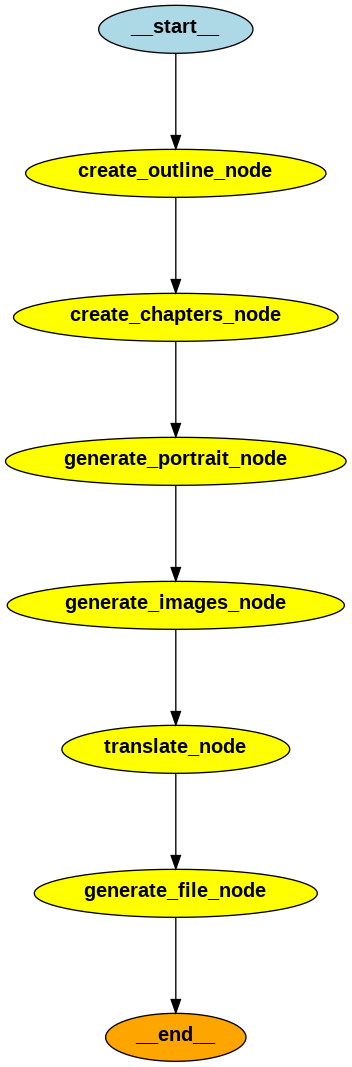

In [64]:

from IPython.display import Image

Image(workflow.get_graph().draw_png())


In [103]:
topic = "续写一位霸道女总裁的故事。她从外交学院毕业之后，经过多年奋斗，终于进入了一家知名企业当副总裁，然而她对下属员工非常刻薄，她在个人抖音账号上发布了多条视频，包括“员工闹分手提离职我秒批”、“300封举报信撒满工位”等话题，这些视频内容引发了公众的热议和争议，终于被公司辞退。被公司辞退前她自己注册了一家公司。"

In [69]:
topic="Continuing to write the story of a domineering female CEO. After graduating from the School of Foreign Affairs, she worked hard for many years and finally joined a well-known company as the vice president. However, she was very harsh towards her subordinates, which led to her being publicly posted online and reported, and finally dismissed by the company. Before being dismissed by the company, she registered a company herself."

In [104]:
steps = []
init_state = {
    "env_var":{},
    "messages":[HumanMessage(content=f"Here is the topic:{topic}")]
}


In [105]:
async for event in workflow.astream(input=init_state):
    steps.append(event)
    for key, value in event.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

---generate_outline---
<thinking>
Based on the user-provided topic, here is a comprehensive outline for a comics book about a powerful female CEO's story:
</thinking>

<answer>
{
  "page_title": "The Rise and Fall of the Ruthless CEO",
  "chapters": [
    {
      "chapter_title": "Ambitious Graduate",
      "description": "The story begins with the protagonist, a young woman named Ling, graduating from the prestigious Foreign Affairs College. Determined to make her mark in the corporate world, Ling sets her sights on joining a renowned company."
    },
    {
      "chapter_title": "Climbing the Corporate Ladder",
      "description": "After graduation, Ling embarks on a journey of hard work and dedication, steadily rising through the ranks of the company. Her sharp intellect, ruthless ambition, and willingness to do whatever it takes to succeed earn her the respect and fear of her colleagues."
    },
    {
      "chapter_title": "Becoming the Vice President",
      "description": "Ling

CancelledError: 

In [90]:
inter_state = AgentState(steps[-1]['generate_images_node'])

In [97]:
translate_state = await translate_node(inter_state)

<thinking>
To translate the given content from English to Chinese, I will:

1. Extract the chapter title and paragraphs from the JSON data.
2. Translate the chapter title and each paragraph into concise and easy-to-understand Chinese, while accurately conveying the facts and background of the original text.
3. Avoid using quotation marks within quotation marks, and use single quotation marks instead if necessary.
4. Output the translated content in the specified JSON format, enclosed in <answer> tags.
</thinking>

<answer>
{
  "chapter_title": "铁腕统治",
  "paragraphs": [
    {
      "content": "萨曼莎严厉的领导手腕给下属带来了沉重的压力,尤其是艾米丽这位曾经钦佩她野心勃勃的优秀勤恳员工。随着萨曼莎的要求变得越来越无理,艾米丽开始对上级缺乏同理心和同情心感到愤懑。"
    },
    {
      "content": "艾米丽起初被萨曼莎的进取心和决心所吸引,认为她是一个与自己心有灵犀、不惜一切代价实现目标的人。但萨曼莎的管理风格是绝对控制,不容有任何错误或偏离她严格标准的行为。她逼迫团队走向极限,要求长时间加班,每项任务都必须完美无缺,无视员工的个人代价。"
    },
    {
      "content": "资深行政人员大卫曾经是萨曼莎的导师,如今他越来越担心公司文化在她铁腕统治下发生了改变。他很早就看到了萨曼莎的潜力,并帮助她一步步攀升,但现在他开始质疑她的野心是否蒙蔽了对团队需求的关注。"
    },
    {
      "content": "随着

In [99]:
await generate_file_node(translate_state)

content='Samantha had always been driven, a trait instilled in her from a young age by her hardworking parents. Growing up in a modest household, she witnessed firsthand the sacrifices her parents made to provide for their family. Her father, a factory worker, and her mother, a seamstress, impressed upon Samantha the value of perseverance and the belief that with enough determination, one could overcome any obstacle.'
content='Determined to forge a path beyond the constraints of her small-town upbringing, Samantha excelled academically, earning a scholarship to the prestigious School of Foreign Affairs. There, her sharp intellect and strategic thinking skills quickly set her apart from her peers. She navigated the rigorous curriculum with ease, tackling complex case studies and honing her negotiation tactics, all the while driven by an unwavering ambition to climb the corporate ladder.'
content='It was during a career fair at the school that Samantha caught the eye of David, a seasoned

{'env_var': {'outline': Outline(page_title='The Rise and Fall (and Rise Again) of a Ruthless Female CEO', chapters=[Chapter(chapter_title='Ambition Takes Flight', description='Introduces Samantha, a driven and ambitious young woman who graduates from the prestigious School of Foreign Affairs. Determined to climb the corporate ladder, she lands a job as a vice president at a well-known company, where she quickly establishes herself as a force to be reckoned with through her ruthless management style and relentless pursuit of success.'), Chapter(chapter_title='The Iron Fist', description="Samantha's harsh leadership tactics begin to take a toll on her subordinates, including Emily, a talented and hardworking employee who initially admired Samantha's drive but now finds herself increasingly resentful of the unreasonable demands and lack of empathy. As tensions rise, Samantha's superior, David, a seasoned executive who had once mentored her, becomes increasingly concerned about the impact 